<a href="https://colab.research.google.com/github/HurleyJames/GoogleColabExercise/blob/master/AI_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from  torch.utils.data import Dataset
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

In [2]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

fatal: destination path 'imagenet10' already exists and is not an empty directory.


In [3]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

In [7]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/canoe/n02951358_13751.JPEG,2
1,imagenet10/train_set/drill/n03239726_9604.JPEG,5
2,imagenet10/train_set/canoe/n02951358_343.JPEG,2
3,imagenet10/train_set/desk/n03179701_24731.JPEG,4
4,imagenet10/train_set/drill/n03239726_13045.JPEG,5


In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs

In [10]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:41<00:00, 217.69it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10
# 测试集
# test_split = 0.20

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)
# 测试集大小
# test_size = int(len(data_df)*test_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

创建数据集

In [0]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=24,
    # batch_size=10,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=24,
    # batch_size=15,
    shuffle=False,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=32,
    # batch_size=30,
    shuffle=False,
    num_workers=2
)

In [14]:
len(train_loader)

263

In [15]:
len(valid_loader)

38

In [16]:
len(test_loader)

57

# CNN网络

In [0]:
train = []
valid = []
train2 = []
train3 = []
train4 = []
train5 = []
valid2 = []
valid3 = []
valid4 = []
valid5 = []

测试设备是否支持GPU

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### 2层卷积层

In [19]:
# Convolutional neural network
class ConvNet2(nn.Module):

    def __init__(self, num_classes=10):
        super(ConvNet2, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        
        self.fc1 = nn.Linear(24*62*62, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = x.view(-1, 24*62*62) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

model2 = ConvNet2()
print(model2)

ConvNet2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=92256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
)


### 3层卷积层

In [20]:
# Convolutional neural network
class ConvNet3(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet3, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.conv3 = nn.Conv2d(24, 32, 4)

        self.fc1 = nn.Linear(32*29*29, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)
        self.dropout3 = nn.Dropout2d(0.3)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = x.view(-1, 32*29*29) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

model3 = ConvNet3()
print(model3)

ConvNet3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=26912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
)


### 4层卷积层

In [21]:
# Convolutional neural network
class ConvNet4(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet4, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.conv3 = nn.Conv2d(24, 32, 4)
        self.conv4 = nn.Conv2d(32, 40, 4)

        self.fc1 = nn.Linear(40*13*13, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)
        self.dropout3 = nn.Dropout2d(0.3)
        self.dropout4 = nn.Dropout2d(0.3)
        
    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 40*13*13) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

model4 = ConvNet4()
print(model4)

ConvNet4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
  (dropout4): Dropout2d(p=0.3, inplace=False)
)


### 5层卷积层

In [22]:
# Convolutional neural network
class ConvNet5(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.conv3 = nn.Conv2d(24, 32, 4)
        self.conv4 = nn.Conv2d(32, 40, 4)
        self.conv5 = nn.Conv2d(40, 48, 4)

        self.fc1 = nn.Linear(48*5*5, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)
        self.pool5 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)
        self.dropout3 = nn.Dropout2d(0.3)
        self.dropout4 = nn.Dropout2d(0.3)
        self.dropout5 = nn.Dropout2d(0.3)

        
    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = self.pool5(F.relu(self.conv5(x)))
        x = self.dropout5(x)

        x = x.view(-1, 48*5*5) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

model5 = ConvNet5()
print(model5)

ConvNet5(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv5): Conv2d(40, 48, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=1200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=F

### 定义优化器和损失函数

In [0]:
from torch import optim

torch.manual_seed(0)

# 四个优化器分别对应四个模型
optimizer2 = optim.SGD(model2.parameters(), lr = 0.001, momentum = 0.9)
optimizer3 = optim.SGD(model3.parameters(), lr = 0.001, momentum = 0.9)
optimizer4 = optim.SGD(model4.parameters(), lr = 0.001, momentum = 0.9)
optimizer5 = optim.SGD(model5.parameters(), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

将模型放在GPU上

In [24]:
model2.to(device)

ConvNet2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=92256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
)

In [25]:
model3.to(device)

ConvNet3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=26912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
)

In [26]:
model4.to(device)

ConvNet4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
  (dropout4): Dropout2d(p=0.3, inplace=False)
)

In [27]:
model5.to(device)

ConvNet5(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (conv5): Conv2d(40, 48, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=1200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=F

### 训练网络

可视化卷积核方法

In [0]:
def filter_visual():
  figure = plt.figure(figsize = (15, 15))
  k = 0

  for i in range(16):
    
    filter_mix = np.zeros(shape = [3,3])
    for j in range(3):
      k = k + 1
      figure.add_subplot(8, 6, k)
      filter_mix += model.conv1.weight.data.cpu().numpy()[ i, j, :, :]
      plt.imshow(filter_mix, cmap = "gray")
  plt.show()

损失率和准确率的列表

In [0]:
loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

model2_train_loss = []
model2_valid_loss = []
model2_train_acc = []
model2_valid_acc = []

model3_train_loss = []
model3_valid_loss = []
model3_train_acc = []
model3_valid_acc = []

model4_train_loss = []
model4_valid_loss = []
model4_train_acc = []
model4_valid_acc = []

model5_train_loss = []
model5_valid_loss = []
model5_train_acc = []
model5_valid_acc = []

训练轮数

In [0]:
EPOCH = 10

训练和验证模型方法

In [0]:
def train_and_valid(num_epochs, model, optimizer, flag):  
    for epoch in range(num_epochs): 
        correct = 0
        total = 0 # loop over the dataset multiple times

        running_loss = 0.0
        total_val_loss =0.0

        if (epoch ==5 and flag ==1):
            filter_visual()
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print our loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Epoch %d - Loss : %.3f' % (epoch+1,running_loss/len(train_loader)))
        print('The accuracy of training set is %.3f %%' % (correct/total*100))
        loss_lst.append(running_loss/len(train_loader))
        acc_lst.append(correct/total*100)

        with torch.no_grad():
            val_correct = 0 
            val_total = 0
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                    
                val_outputs = model(inputs)
                val_loss = loss_fn(val_outputs, labels)
                total_val_loss += val_loss.item()
                _,prediction = torch.max(val_outputs.data,1)
                val_total += labels.size(0)
                val_correct += (prediction == labels).sum().item()
        print("Validation loss = {:.2f}".format(total_val_loss / len(valid_loader)))
        print('The accuracy of Validation set is %.3f %%' %(val_correct/val_total*100))

        val_loss_lst.append(total_val_loss / len(valid_loader))
        val_acc_lst.append(val_correct/val_total*100)
        
    print('Finished')    

绘制混淆矩阵的方法

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #fmt = '.2f' if normalize else 'd'
    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(100,100)) 

绘制损失函数或准确率的方法

In [0]:
def draw_plot(train, valid):
    x = np.arange(0, 10)

    plt.figure()
    plt.plot(x, train, "r", "-", linewidth=1)

    plt.plot(x, valid, "b", ":", linewidth=1)

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("finding converge by loss")

### 训练2层模型

In [34]:
model2.train()
train_and_valid(EPOCH, model2, optimizer2, 0)

model2_train_loss = loss_lst
model2_valid_loss = val_loss_lst
model2_train_acc = acc_lst
model2_valid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

Epoch 1 - Loss : 2.193
The accuracy of training set is 19.841 %
Validation loss = 2.07
The accuracy of Validation set is 26.111 %
Epoch 2 - Loss : 1.966
The accuracy of training set is 30.619 %
Validation loss = 1.96
The accuracy of Validation set is 29.111 %
Epoch 3 - Loss : 1.824
The accuracy of training set is 35.667 %
Validation loss = 1.84
The accuracy of Validation set is 32.444 %
Epoch 4 - Loss : 1.724
The accuracy of training set is 40.095 %
Validation loss = 1.81
The accuracy of Validation set is 35.778 %
Epoch 5 - Loss : 1.634
The accuracy of training set is 43.476 %
Validation loss = 1.76
The accuracy of Validation set is 40.333 %
Epoch 6 - Loss : 1.541
The accuracy of training set is 47.381 %
Validation loss = 1.71
The accuracy of Validation set is 41.000 %
Epoch 7 - Loss : 1.463
The accuracy of training set is 50.921 %
Validation loss = 1.77
The accuracy of Validation set is 40.000 %
Epoch 8 - Loss : 1.359
The accuracy of training set is 54.714 %
Validation loss = 1.80
The

训练集和验证集的损失函数图

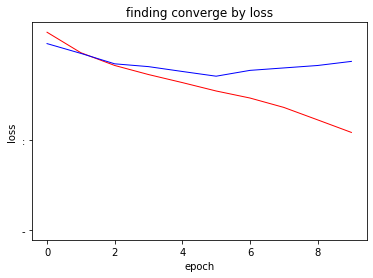

In [35]:
draw_plot(model2_train_loss, model2_valid_loss)

训练集和验证集的准确率图

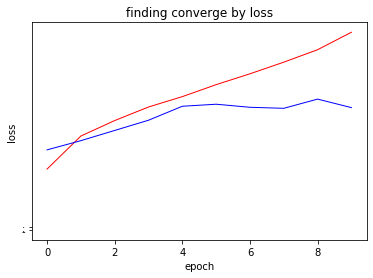

In [36]:
draw_plot(model2_train_acc, model2_valid_acc)

计算2层模型准确率

In [37]:
model2.eval()
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model2(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 716
total: 1800
Accuracy of the network on the images: 39 %
Accuracy of baboon: 35 %
Accuracy of banana: 26 %
Accuracy of canoe: 53 %
Accuracy of   cat: 50 %
Accuracy of  desk: 20 %
Accuracy of drill: 35 %
Accuracy of dumbbell: 23 %
Accuracy of football: 24 %
Accuracy of   mug: 29 %
Accuracy of orange: 86 %


混淆矩阵

Normalized confusion matrix
[[ 81   6  14  35   7   8  18  16   1   4]
 [  6  54   8  10   3   7   4  10  15  60]
 [ 12   9  88  22  18   4  10  11  13   4]
 [ 13   6  10  85   6  10  12  18  12   5]
 [  5   4  22  21  43  18  18   9  27   6]
 [  5   2   6  17  11  67  12   6  16   7]
 [  6   4  15  16  28  19  47  26  20   6]
 [ 15  13  18  31   5  15  12  43  19  11]
 [ 14   8   8  22  11   8  18  13  71  17]
 [  3  20   2   3   2   1   2   4  10 137]]


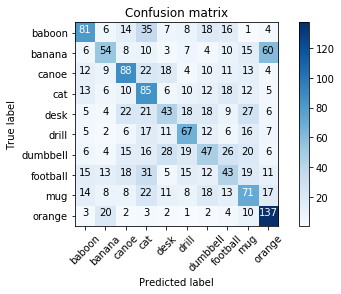

<Figure size 7200x7200 with 0 Axes>

In [38]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

### 训练3层模型

In [39]:
model3.train()
train_and_valid(EPOCH, model3, optimizer3, 0)

model3_train_loss = loss_lst
model3_valid_loss = val_loss_lst
model3_train_acc = acc_lst
model3_valid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

Epoch 1 - Loss : 2.262
The accuracy of training set is 14.873 %
Validation loss = 2.19
The accuracy of Validation set is 21.222 %
Epoch 2 - Loss : 2.114
The accuracy of training set is 24.254 %
Validation loss = 2.06
The accuracy of Validation set is 25.556 %
Epoch 3 - Loss : 1.994
The accuracy of training set is 28.746 %
Validation loss = 1.97
The accuracy of Validation set is 30.111 %
Epoch 4 - Loss : 1.938
The accuracy of training set is 31.540 %
Validation loss = 1.98
The accuracy of Validation set is 31.444 %
Epoch 5 - Loss : 1.884
The accuracy of training set is 34.206 %
Validation loss = 1.90
The accuracy of Validation set is 33.556 %
Epoch 6 - Loss : 1.815
The accuracy of training set is 36.333 %
Validation loss = 1.87
The accuracy of Validation set is 32.889 %
Epoch 7 - Loss : 1.759
The accuracy of training set is 38.397 %
Validation loss = 1.85
The accuracy of Validation set is 33.778 %
Epoch 8 - Loss : 1.696
The accuracy of training set is 40.968 %
Validation loss = 1.84
The

训练集和验证集的损失函数图

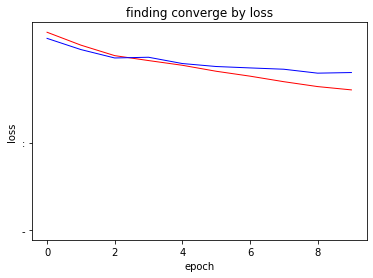

In [40]:
draw_plot(model3_train_loss, model3_valid_loss)

训练集和验证集的准确率图

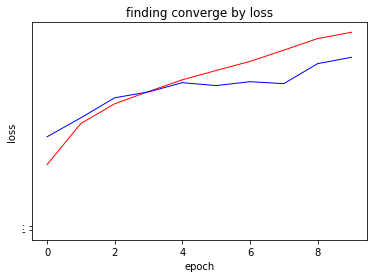

In [41]:
draw_plot(model3_train_acc, model3_valid_acc)

计算3层模型准确率

In [42]:
model3.eval()
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model3(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 746
total: 1800
Accuracy of the network on the images: 41 %
Accuracy of baboon: 58 %
Accuracy of banana: 28 %
Accuracy of canoe: 53 %
Accuracy of   cat: 38 %
Accuracy of  desk: 26 %
Accuracy of drill: 38 %
Accuracy of dumbbell: 21 %
Accuracy of football: 34 %
Accuracy of   mug: 16 %
Accuracy of orange: 78 %


混淆矩阵

Normalized confusion matrix
[[127   2  19  20   4   7   2   7   0   2]
 [  6  57  12  10   4   3   0   8   8  69]
 [ 18  12 111  15   9   5   2  16   2   1]
 [ 45   9  14  68   9   7   3  16   4   2]
 [ 19   7  40  17  41  18   4  16   8   3]
 [ 15   6   5  17   8  68   6  12   6   6]
 [ 32  13  22  26  12  31  36   8   5   2]
 [ 27  18  19  21   5  15   7  60   6   4]
 [ 34  15  16  13   8  15  13  15  46  15]
 [  1  35   2   2   2   2   0   0   8 132]]


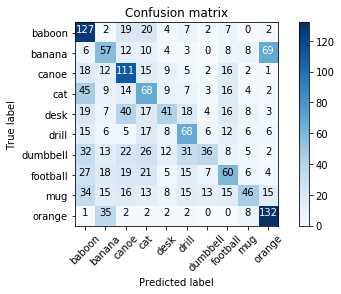

<Figure size 7200x7200 with 0 Axes>

In [43]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

### 训练4层模型

In [44]:
model4.train()
train_and_valid(EPOCH, model4, optimizer4, 0)

model4_train_loss = loss_lst
model4_valid_loss = val_loss_lst
model4_train_acc = acc_lst
model4_valid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

Epoch 1 - Loss : 2.302
The accuracy of training set is 11.270 %
Validation loss = 2.30
The accuracy of Validation set is 11.889 %
Epoch 2 - Loss : 2.277
The accuracy of training set is 13.048 %
Validation loss = 2.25
The accuracy of Validation set is 14.444 %
Epoch 3 - Loss : 2.236
The accuracy of training set is 17.143 %
Validation loss = 2.22
The accuracy of Validation set is 19.667 %
Epoch 4 - Loss : 2.188
The accuracy of training set is 20.825 %
Validation loss = 2.12
The accuracy of Validation set is 21.889 %
Epoch 5 - Loss : 2.099
The accuracy of training set is 24.730 %
Validation loss = 2.05
The accuracy of Validation set is 25.667 %
Epoch 6 - Loss : 2.035
The accuracy of training set is 27.635 %
Validation loss = 2.01
The accuracy of Validation set is 30.222 %
Epoch 7 - Loss : 1.981
The accuracy of training set is 30.365 %
Validation loss = 2.00
The accuracy of Validation set is 30.667 %
Epoch 8 - Loss : 1.949
The accuracy of training set is 32.222 %
Validation loss = 1.97
The

训练集和验证集的损失函数图

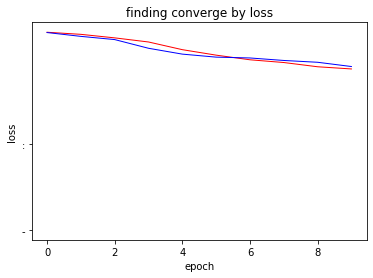

In [45]:
draw_plot(model4_train_loss, model4_valid_loss)

训练集和验证集的准确率图

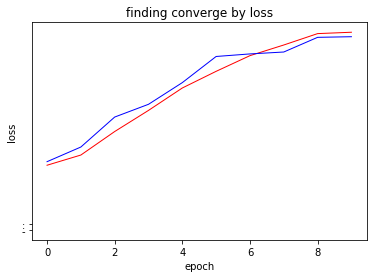

In [46]:
draw_plot(model4_train_acc, model4_valid_acc)

计算4层模型准确率

In [47]:
model4.eval()

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model4(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 592
total: 1800
Accuracy of the network on the images: 32 %
Accuracy of baboon: 30 %
Accuracy of banana:  2 %
Accuracy of canoe: 63 %
Accuracy of   cat: 36 %
Accuracy of  desk: 12 %
Accuracy of drill: 38 %
Accuracy of dumbbell: 23 %
Accuracy of football: 12 %
Accuracy of   mug: 18 %
Accuracy of orange: 86 %


混淆矩阵

Normalized confusion matrix
[[ 48   4  54  40  10   9   9   6   7   3]
 [  2  25  21  14   3   8   3   0   5  96]
 [  5   1 112  26  14  12   4   6   4   7]
 [ 20   1  32  65  17  14   8   5   4  11]
 [  7   3  69  27  22  18   6   8   8   5]
 [  6   0  16  18  10  69   8   2  10  10]
 [ 15   2  42  20  15  31  39   4  12   7]
 [ 14   7  36  33  20  13  11  21  14  13]
 [ 16   8  25  26   9  17  16   9  42  22]
 [  1  14   6   4   1   5   0   0   4 149]]


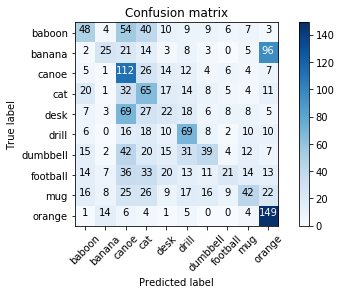

<Figure size 7200x7200 with 0 Axes>

In [48]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

### 训练5层模型

In [49]:
model5.train()
train_and_valid(EPOCH, model5, optimizer5, 0)

model5_train_loss = loss_lst
model5_valid_loss = val_loss_lst
model5_train_acc = acc_lst
model5_valid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

Epoch 1 - Loss : 2.302
The accuracy of training set is 10.381 %
Validation loss = 2.30
The accuracy of Validation set is 10.111 %
Epoch 2 - Loss : 2.301
The accuracy of training set is 10.476 %
Validation loss = 2.30
The accuracy of Validation set is 10.111 %
Epoch 3 - Loss : 2.297
The accuracy of training set is 11.079 %
Validation loss = 2.29
The accuracy of Validation set is 13.333 %
Epoch 4 - Loss : 2.277
The accuracy of training set is 14.175 %
Validation loss = 2.26
The accuracy of Validation set is 14.667 %
Epoch 5 - Loss : 2.241
The accuracy of training set is 18.143 %
Validation loss = 2.24
The accuracy of Validation set is 19.000 %
Epoch 6 - Loss : 2.208
The accuracy of training set is 20.206 %
Validation loss = 2.20
The accuracy of Validation set is 21.111 %
Epoch 7 - Loss : 2.184
The accuracy of training set is 21.206 %
Validation loss = 2.17
The accuracy of Validation set is 21.222 %
Epoch 8 - Loss : 2.110
The accuracy of training set is 23.143 %
Validation loss = 2.09
The

训练集和验证集的损失函数图

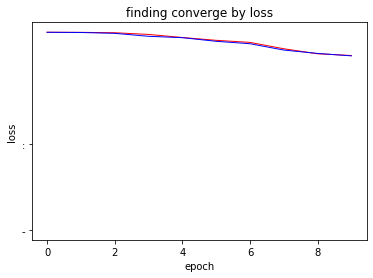

In [50]:
draw_plot(model5_train_loss, model5_valid_loss)

训练集和验证集的准确率图

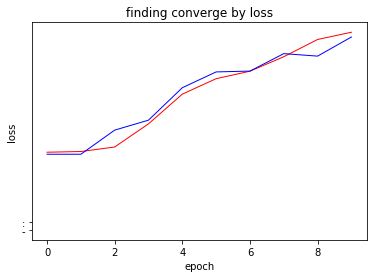

In [51]:
draw_plot(model5_train_acc, model5_valid_acc)

计算5层模型准确率

In [52]:
model5.eval()

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model5(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 483
total: 1800
Accuracy of the network on the images: 26 %
Accuracy of baboon:  5 %
Accuracy of banana: 15 %
Accuracy of canoe: 30 %
Accuracy of   cat:  7 %
Accuracy of  desk:  6 %
Accuracy of drill: 38 %
Accuracy of dumbbell: 19 %
Accuracy of football: 34 %
Accuracy of   mug: 13 %
Accuracy of orange: 57 %


混淆矩阵

Normalized confusion matrix
[[ 19   8  33  14   5  15  37  28  22   9]
 [  0  41   7   8   2   8   7  20   6  78]
 [  0   7  63  10   9  26  22  38  13   3]
 [  9   7  22  26   5  21  16  46  12  13]
 [  1   5  41  12   9  31  10  46  13   5]
 [  3   4  10  10   1  74  11  20  12   4]
 [  8   4  25   5   5  44  46  31  15   4]
 [  7   8  27  12   5  20  17  67   8  11]
 [  7  10  11   9   5  29  33  38  37  11]
 [  1  56   3   2   0   5   1  10   5 101]]


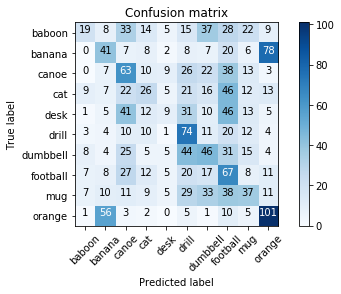

<Figure size 7200x7200 with 0 Axes>

In [53]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

### 选取4层网络，并改变参数

In [54]:
# Convolutional neural network
class ReConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ReConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 24, 4)
        self.conv3 = nn.Conv2d(24, 32, 4)
        self.conv4 = nn.Conv2d(32, 40, 4)

        self.fc1 = nn.Linear(40*13*13, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.1)
        self.dropout2 = nn.Dropout2d(0.1)
        self.dropout3 = nn.Dropout2d(0.1)
        self.dropout4 = nn.Dropout2d(0.1)
        
    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 40*13*13) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool1(feature_map1)
        x = F.dropout2d(x, 0.1)

        feature_map2 = F.relu(self.conv2(x))
        x = self.pool2(feature_map2)
        x = F.dropout2d(x, 0.1)

        feature_map3 = F.relu(self.conv3(x))
        x = self.pool3(feature_map3)
        x = F.dropout2d(x, 0.1)

        feature_map4 = F.relu(self.conv4(x))
        x = self.pool4(feature_map4)
        x = F.dropout2d(x, 0.1)

        # x = self.conv1(x)
        # feature_map1 = x
        # x = self.conv2[0](x)
        # feature_map2 = x
        # x = self.conv3[0](x)
        # feature_map3 = x
        # x = self.conv4[0](x)
        # feature_map4 = x

        return (feature_map1, feature_map2, feature_map3, feature_map4)

model = ReConvNet()
print(model)

ReConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout4): Dropout2d(p=0.1, inplace=False)
)


定义优化器和损失函数

In [0]:
from torch import optim

torch.manual_seed(0)

optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

将模型放在GPU上

In [56]:
model.to(device)

ReConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout4): Dropout2d(p=0.1, inplace=False)
)

训练前的卷积核可视化

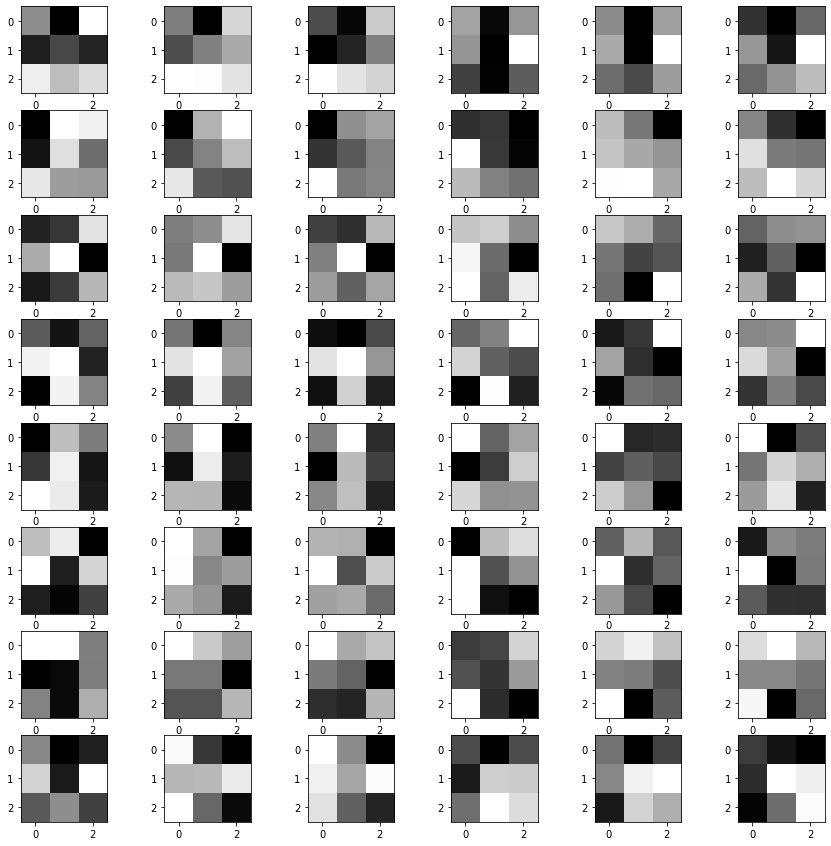

In [58]:
filter_visual()

In [0]:
retrain_loss = []
revalid_loss = []
retrain_acc = []
revalid_acc = []

训练网络与训练中的卷积核可视化

Epoch 1 - Loss : 1.898
The accuracy of training set is 33.365 %
Validation loss = 1.92
The accuracy of Validation set is 33.444 %
Epoch 2 - Loss : 1.828
The accuracy of training set is 35.413 %
Validation loss = 1.84
The accuracy of Validation set is 36.000 %
Epoch 3 - Loss : 1.753
The accuracy of training set is 38.270 %
Validation loss = 1.80
The accuracy of Validation set is 38.778 %
Epoch 4 - Loss : 1.692
The accuracy of training set is 41.571 %
Validation loss = 1.80
The accuracy of Validation set is 36.889 %
Epoch 5 - Loss : 1.626
The accuracy of training set is 43.095 %
Validation loss = 1.73
The accuracy of Validation set is 41.222 %


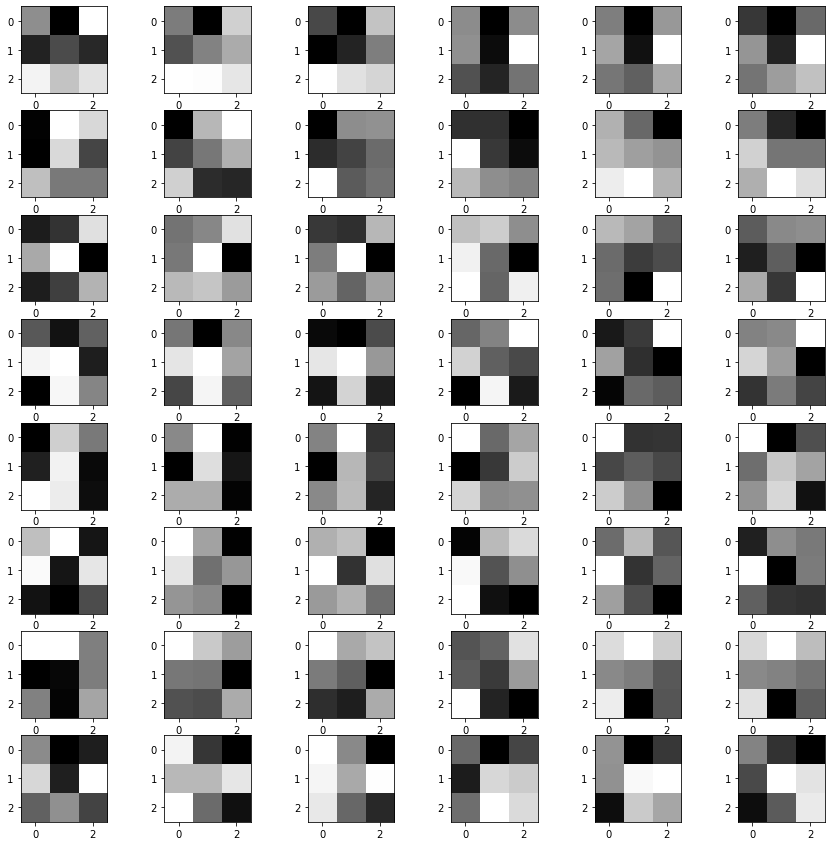

Epoch 6 - Loss : 1.585
The accuracy of training set is 45.429 %
Validation loss = 1.73
The accuracy of Validation set is 40.889 %
Epoch 7 - Loss : 1.491
The accuracy of training set is 49.556 %
Validation loss = 1.77
The accuracy of Validation set is 39.333 %
Epoch 8 - Loss : 1.428
The accuracy of training set is 51.492 %
Validation loss = 1.73
The accuracy of Validation set is 40.556 %
Epoch 9 - Loss : 1.348
The accuracy of training set is 54.524 %
Validation loss = 1.71
The accuracy of Validation set is 43.000 %
Epoch 10 - Loss : 1.229
The accuracy of training set is 58.492 %
Validation loss = 1.73
The accuracy of Validation set is 42.444 %
Finished


In [63]:
model.train()

train_and_valid(EPOCH, model, optimizer, 1)

retrain_loss = loss_lst
revalid_loss = val_loss_lst
retrain_acc = acc_lst
revalid_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

训练后的卷积核可视化

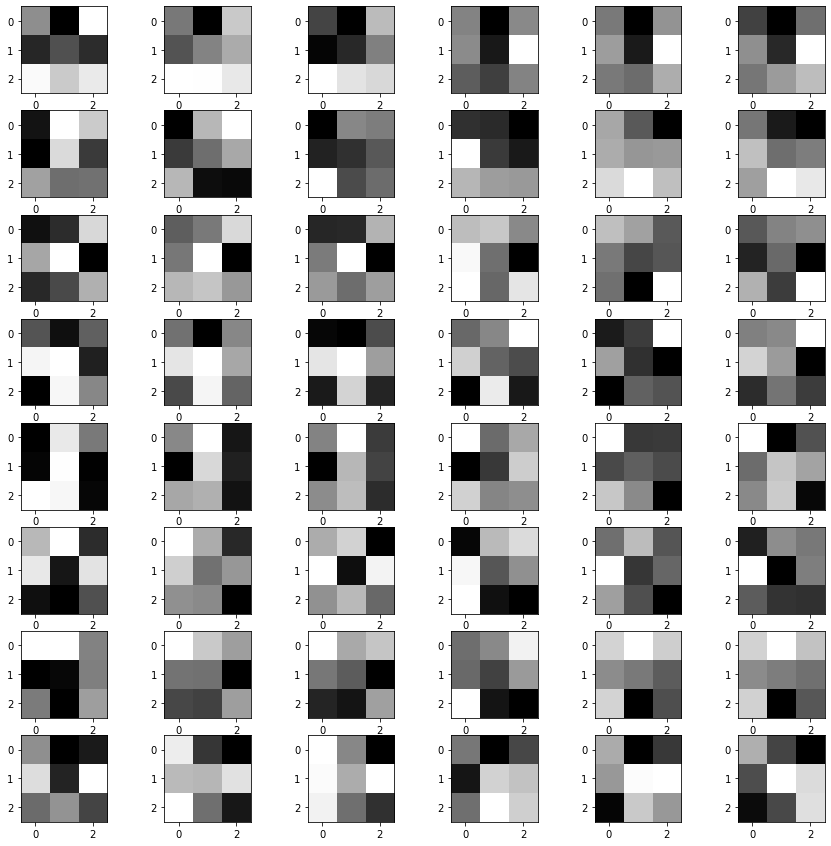

In [64]:
filter_visual()

测试集准确率

In [65]:
model.eval()

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 758
total: 1800
Accuracy of the network on the images: 42 %
Accuracy of baboon: 48 %
Accuracy of banana: 52 %
Accuracy of canoe: 52 %
Accuracy of   cat: 21 %
Accuracy of  desk: 26 %
Accuracy of drill: 33 %
Accuracy of dumbbell: 43 %
Accuracy of football: 30 %
Accuracy of   mug: 37 %
Accuracy of orange: 63 %


混淆矩阵图

Normalized confusion matrix
[[ 91   5  30  14   3   3  20  16   6   2]
 [  2  93  12   4   8   2   5   8  10  33]
 [  9  10 111   7  10   3  10  14  14   3]
 [ 31  13  15  38  13   5  22  28  11   1]
 [  8  13  31   8  43  11  27  12  16   4]
 [  4  11   4  12   9  59  19  10  15   6]
 [ 12   7  12  13  20  10  76  15  17   5]
 [ 15  25  14  12  15   7  19  53  20   2]
 [  7  23   6  12  11   6  22  11  76  16]
 [  2  46   3   1   3   1   0   1   9 118]]


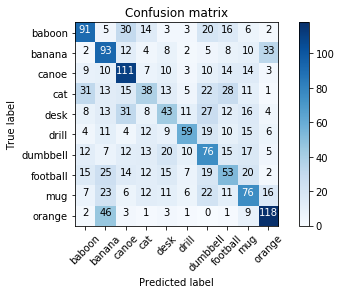

<Figure size 7200x7200 with 0 Axes>

In [66]:
cm = confusion_matrix(labels_true, labels_pred)
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

损失函数图

Text(0.5, 1.0, 'finding converge by loss')

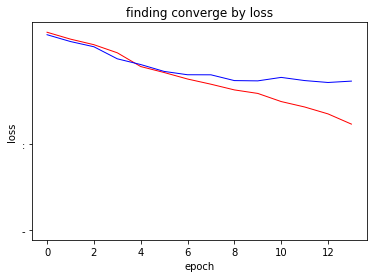

In [68]:
x = np.arange(0, 14)

plt.figure()
plt.plot(x, retrain_loss, "r", "-", linewidth=1)

plt.plot(x, revalid_loss, "b", ":", linewidth=1)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("finding converge by loss")

准确率图

Text(0.5, 1.0, 'finding converge by loss')

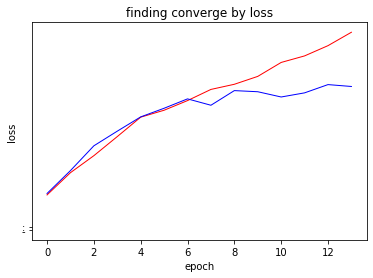

In [69]:
x = np.arange(0, 14)

plt.figure()
plt.plot(x, retrain_acc, "r", "-", linewidth=1)

plt.plot(x, revalid_acc, "b", ":", linewidth=1)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("finding converge by loss")

# 特征图可视化

### 绘制第一层特征图

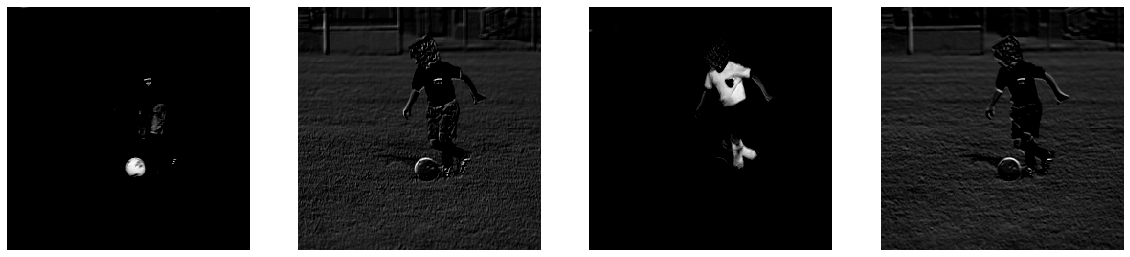

In [70]:
idx = 1000
idy = 500

input_x = ins_dataset_test[idx][0].unsqueeze(0)
input_y = ins_dataset_test[idy][0].unsqueeze(0)
feature_maps_x = model.retrieve_features(input_x.to(device))
feature_maps_y = model.retrieve_features(input_y.to(device))

plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[0][0, i, ...].data.cpu().numpy(), cmap='gray')

### 绘制第二层特征图

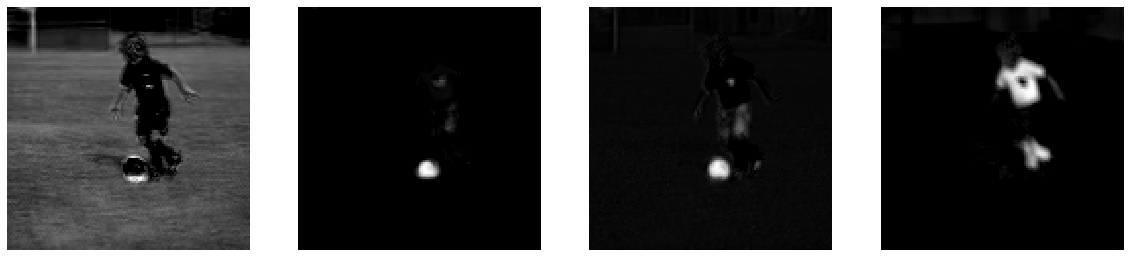

In [71]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(2 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[1][0, i,...].data.cpu().numpy(), cmap='gray')

### 绘制第三层特征图

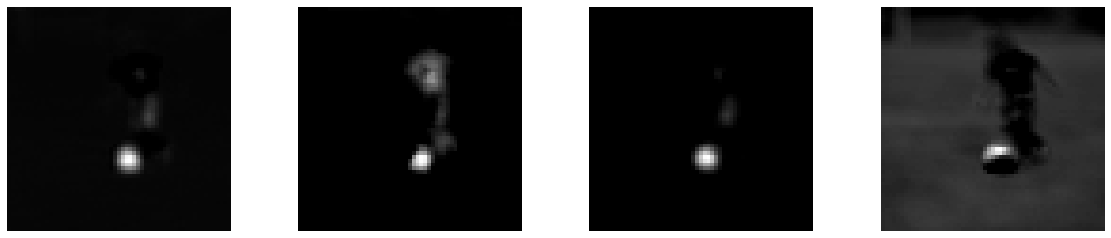

In [72]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(3 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[2][0, i,...].data.cpu().numpy(), cmap='gray')

### 绘制第四层特征图

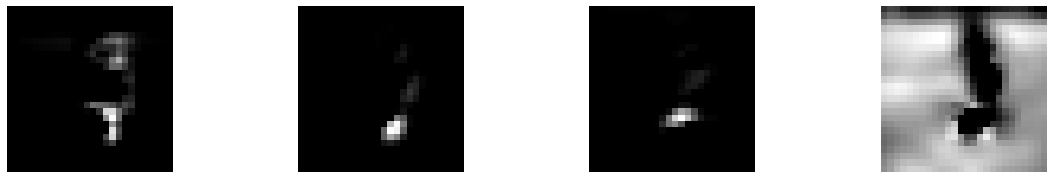

In [73]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(4 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[3][0, i,...].data.cpu().numpy(), cmap='gray')

绘制第一层特征图

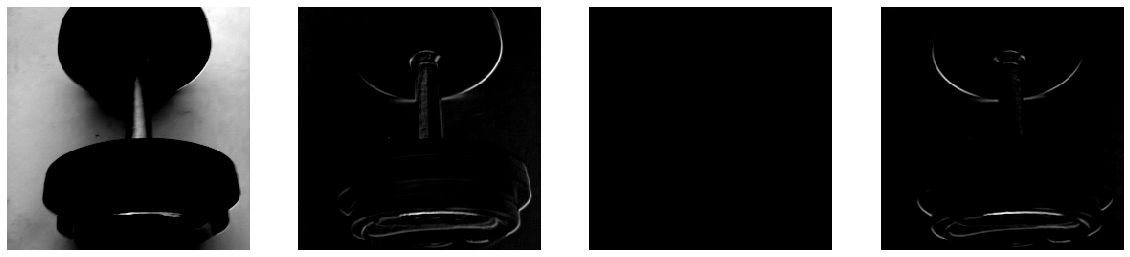

In [74]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[0][0, i, ...].data.cpu().numpy(), cmap='gray')

绘制第二层特征图

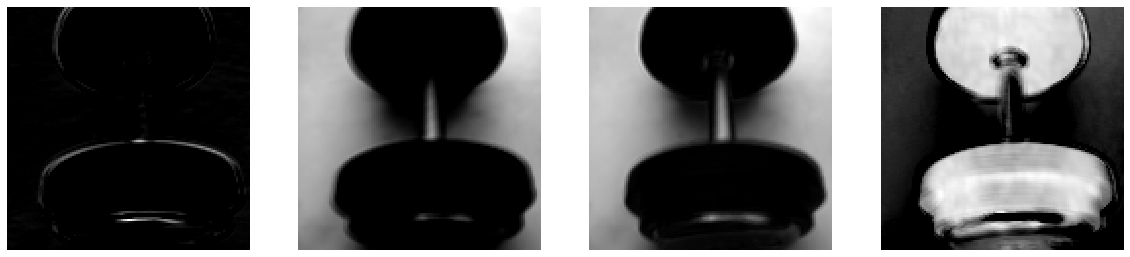

In [75]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[1][0, i, ...].data.cpu().numpy(), cmap='gray')

绘制第三层特征图

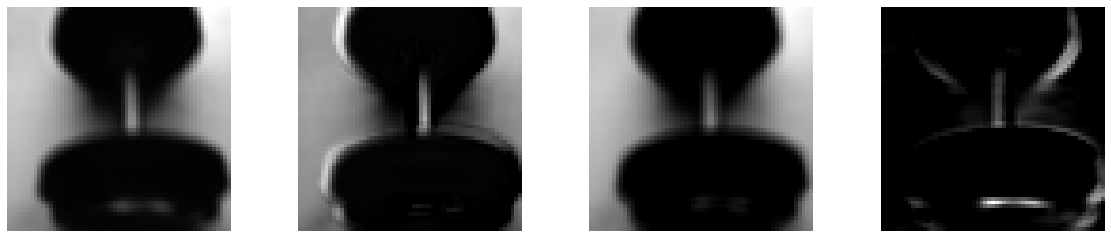

In [76]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[2][0, i, ...].data.cpu().numpy(), cmap='gray')

绘制第四层特征图

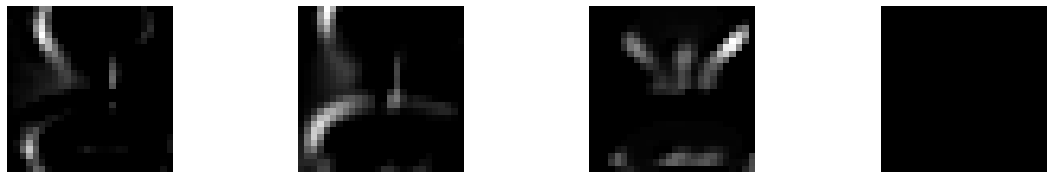

In [77]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[3][0, i, ...].data.cpu().numpy(), cmap='gray')

# 提升网络性能

In [79]:
from torchvision import models

final_model = models.resnet18(pretrained = False)

# 冻结预训练网络中的参数
for param in final_model.parameters():
    param.require_grad = False

final_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# from collections import OrderedDict

# classifier = nn.Sequential(OrderedDict([
#                             ('fc1', nn.Linear(25088, 4096)),
#                             ('relu1', nn.ReLU()),
#                             ('fc2', nn.Linear(4096, 1000)),
#                             ('relu2', nn.ReLU()),
#                             ('fc3', nn.Linear(1000, 10)),
#                             ('output', nn.LogSoftmax(dim=1))
# ]))

# final_model.classifier = classifier

定义优化器和损失函数

In [0]:
loss_fn = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.parameters(), lr = 0.001)

In [81]:
final_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
final_train_loss = []
final_valid_loss = []
final_train_acc = []
final_val_acc = []

In [83]:
train_and_valid(EPOCH, final_model, final_optimizer, 0)

Epoch 1 - Loss : 2.029
The accuracy of training set is 29.016 %
Validation loss = 1.84
The accuracy of Validation set is 35.778 %
Epoch 2 - Loss : 1.683
The accuracy of training set is 40.937 %
Validation loss = 1.61
The accuracy of Validation set is 44.889 %
Epoch 3 - Loss : 1.508
The accuracy of training set is 47.857 %
Validation loss = 1.46
The accuracy of Validation set is 49.444 %
Epoch 4 - Loss : 1.401
The accuracy of training set is 53.270 %
Validation loss = 1.44
The accuracy of Validation set is 49.000 %
Epoch 5 - Loss : 1.300
The accuracy of training set is 55.079 %
Validation loss = 1.31
The accuracy of Validation set is 55.000 %
Epoch 6 - Loss : 1.221
The accuracy of training set is 57.889 %
Validation loss = 1.27
The accuracy of Validation set is 55.444 %
Epoch 7 - Loss : 1.128
The accuracy of training set is 62.016 %
Validation loss = 1.24
The accuracy of Validation set is 57.667 %
Epoch 8 - Loss : 1.083
The accuracy of training set is 62.635 %
Validation loss = 1.16
The

In [0]:
final_train_loss = loss_lst
final_valid_loss = val_loss_lst
final_train_acc = acc_lst 
final_val_acc = val_acc_lst

loss_lst = []
val_loss_lst = []
acc_lst = []
val_acc_lst = []

绘制损失函数图像

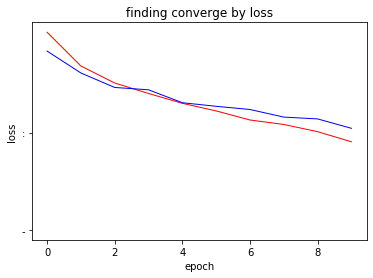

In [86]:
draw_plot(final_train_loss, final_valid_loss)

绘制准确率图像

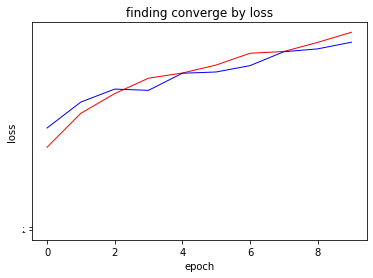

In [87]:
draw_plot(final_train_acc, final_val_acc)

测试集准确率

In [88]:
final_model.eval()

correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = torch.zeros(0, dtype=torch.long, device='cpu')
labels_pred = torch.zeros(0, dtype=torch.long, device='cpu')

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = final_model(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = torch.cat([labels_true, labels.view(-1).cpu()])
        labels_pred = torch.cat([labels_pred, predicted.view(-1).cpu()])

        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 1203
total: 1800
Accuracy of the network on the images: 66 %
Accuracy of baboon: 74 %
Accuracy of banana: 55 %
Accuracy of canoe: 66 %
Accuracy of   cat: 78 %
Accuracy of  desk: 66 %
Accuracy of drill: 48 %
Accuracy of dumbbell: 54 %
Accuracy of football: 67 %
Accuracy of   mug: 51 %
Accuracy of orange: 89 %


混淆矩阵

In [89]:
cm = confusion_matrix(labels_true, labels_pred)
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[139   4   2  21   0   1  14   8   1   0]
 [  2 102   2  10   4   2   9   6  14  26]
 [  5   0 131   6  11   3   9  23   2   1]
 [ 15   2   0 142   2   0   8   6   2   0]
 [  0   1   0   3 127   9  23   2   7   1]
 [  1   2   1   1  13  79  36  10   5   1]
 [  4   2   2   5  14  19 114  12  13   2]
 [ 10   7   7   4   3   6  26 107  12   0]
 [  1   5   2   7  13  14  21  11 112   4]
 [  1   7   0   4   0   1   7   7   7 150]]


Normalized confusion matrix
[[139   4   2  21   0   1  14   8   1   0]
 [  2 102   2  10   4   2   9   6  14  26]
 [  5   0 131   6  11   3   9  23   2   1]
 [ 15   2   0 142   2   0   8   6   2   0]
 [  0   1   0   3 127   9  23   2   7   1]
 [  1   2   1   1  13  79  36  10   5   1]
 [  4   2   2   5  14  19 114  12  13   2]
 [ 10   7   7   4   3   6  26 107  12   0]
 [  1   5   2   7  13  14  21  11 112   4]
 [  1   7   0   4   0   1   7   7   7 150]]


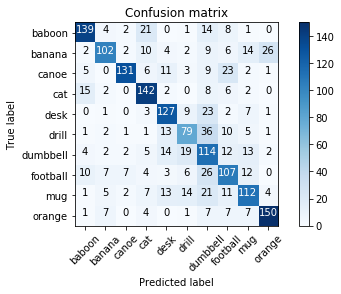

<Figure size 7200x7200 with 0 Axes>

In [90]:
plot_confusion_matrix(cm, class_names, 'Confusion matrix')